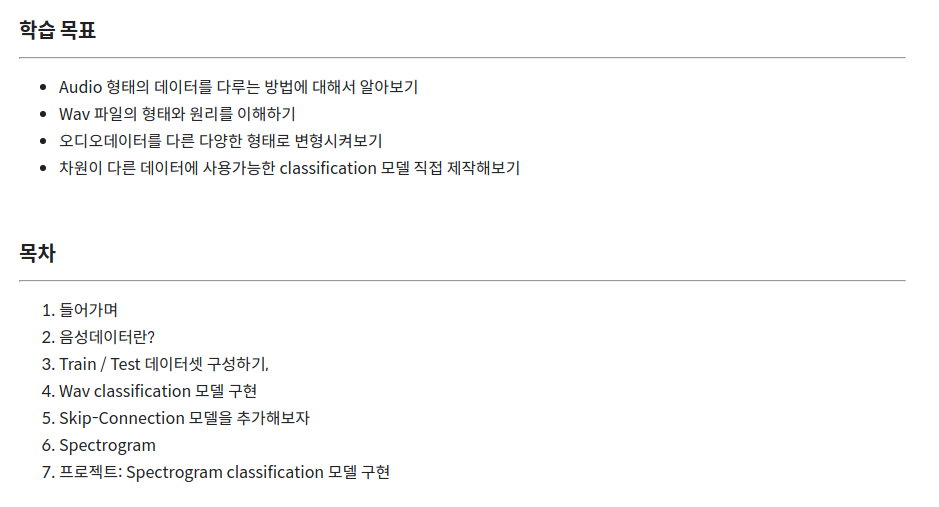

음성은 사람의 소리 오디오는 사람이 아니어도 모든 소리 
음성은 일정한 주파수 영역에만 해당하기 떄문에 일반적인 소리보다 처리가 수월합니다. 

디지털 데이터밖에 처리 못하는 컴퓨터가 어떻게 오디오 데이터를 처리하는지 그 방식과 처리 방법을 알아보도록 하죠~

사람이 소리를 들을 때 물리적인 표현 
컴퓨터가 소리를 인식할 때는? 

https://m.blog.naver.com/PostView.nhn?blogId=leegc96&logNo=221023941249&proxyReferer=https:%2F%2Fwww.google.com%2F

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequency, sampling_rate=16000, duration=1):
    t = np.linspace(0,duration,int(sampling_rate))
    y = np.sin(2*np.pi*frequency*t)
    return y 
y = single_tone(400)

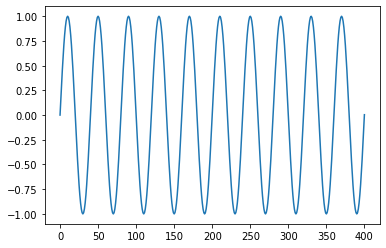

In [2]:
plt.plot(y[:401])
plt.show()

/home/ssac11/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


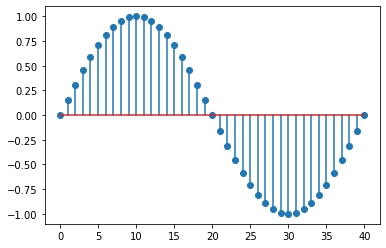

In [3]:
plt.stem(y[:41])
plt.show()

In [4]:
import numpy as np
import os

data_path = os.getenv('HOME')+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [5]:
print('wave data shape:',speech_data['wav_vals'].shape)
print('label data shape:',speech_data['label_vals'].shape)

wave data shape: (50620, 8000)
label data shape: (50620, 1)


In [6]:
import IPython.display as ipd
import random 

rand = random.randint(0,len(speech_data['wav_vals']))
print('rand num:',rand)

sr = 8000 
data = speech_data['wav_vals'][rand]
print('wave data shape:',data.shape)
print('label:',speech_data['label_vals'][rand])

ipd.Audio(data,rate=sr)

rand num: 40389
wave data shape: (8000,)
label: ['up']


In [7]:
target_list = ['yes','no','up','down','left','right',
             'on','off','stop','go']

label_value = target_list 
label_value.append('unknown')
label_value.append('silence')

print('label:',label_value)

new_label_value = dict()
for i,l in enumerate(label_value):#인덱스값을 포함하여 객체를 돌려준다. 
    new_label_value[l] = i #i가 인덱싱 l이 요소
    label_value = new_label_value
print(label_value)

label: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
{'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [8]:
temp = []

for v in speech_data['label_vals']: #약 50000만개의 데이터 중 하나하나 위에서 12개로 클래스가 나누어져 있다고 했음. yes, no, up
    temp.append(label_value[v[0]])# 
label_data = np.array(temp)
print(label_data)

[ 3  3  3 ... 11 11 11]


In [9]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label,test_label = train_test_split(speech_data['wav_vals'], label_data, test_size = 0.1, shuffle = True)
print(train_wav) # train_wav는 8000개의 sampling이 되어있는 하나하나가 train:test 9:1로 나누어져 있음 

train_wav = train_wav.reshape([-1,sr,1]) #cnn을 위한 add channel array의 형태를 모르면 알아서 정할 때 reshape(-1)을 사용합니다. 
test_wav = test_wav.reshape([-1,sr,1]) 

[[-4.0284081e-05 -3.3840592e-05  9.6309479e-05 ...  2.8129955e-04
   4.2768999e-05 -1.9120593e-05]
 [-7.2269613e-05 -1.4918296e-04 -2.7113859e-04 ...  4.3171630e-04
   3.2885338e-04  1.8985872e-04]
 [ 3.3122259e-03  4.7768587e-03  1.4298123e-04 ...  3.4656483e-03
   2.6577520e-03 -1.7022997e-03]
 ...
 [ 1.9432064e-03  3.6628705e-03  3.1797118e-03 ... -1.8511347e-02
  -1.8262276e-02 -2.3134898e-02]
 [ 2.2109183e-03  2.7118428e-03 -1.5158619e-03 ...  1.3027516e-03
   6.1033398e-04 -3.7683393e-03]
 [ 3.8054038e-03 -5.2243493e-02  6.2873513e-03 ... -6.1832573e-03
   2.6817529e-02  1.1318546e-02]]


In [10]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅


In [11]:
batch_size = 32 #모델에 몇개씩 집어넣을 건지 
max_epochs = 10 #학습은 몇 번 돌릴것인가?

checkpoint_dir = os.getenv('HOME') + '/aiffel/speech_recognition/models/wav'
checkpoint_dir

'/home/ssac11/aiffel/speech_recognition/models/wav'

In [12]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [17]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [18]:
import tensorflow as tf
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 8000, 32)          320       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4000, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2000, 64)          0   

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [21]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 1.3402 - accuracy: 0.5566
Epoch 00001: val_loss improved from inf to 1.09790, saving model to /home/ssac11/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 157s 110ms/step - loss: 1.3402 - accuracy: 0.5566 - val_loss: 1.0979 - val_accuracy: 0.6343
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.7536
Epoch 00002: val_loss improved from 1.09790 to 0.69352, saving model to /home/ssac11/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 158s 111ms/step - loss: 0.8007 - accuracy: 0.7536 - val_loss: 0.6935 - val_accuracy: 0.7775
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.8310
Epoch 00003: val_loss improved from 0.69352 to 0.51402, saving model to /home/ssac11/aiffel/speech_recognition/models/wav
1423/1423 [==============================] - 162s 114ms/step - loss: 0

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()